In [1]:
import os, sys
cwd = os.getcwd()
project_path = cwd[:cwd.find('pygents')+7]
if project_path not in sys.path: sys.path.append(project_path)
os.chdir(project_path) 

import math
import pandas as pd
import numpy as np
import random

from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler

from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt


### TODO

- market space
  - metrics
      - trend (price change trend)
      - level based on average (variance/deviation from mean)
      - range and std (measuring volatility)
  - sources
      - price
      - volume (trade, buy, sell)
  - in different horizons - sec, min, hour day
  - with different averages of all of that in these ranges
  - price change probability distribution as a "market regime"!? 
  


3.0 1.0 1.0 1.0 9.999999999999998e-21 0.0 0.0 0.0
3.0 1.0 11.0 1.0 9.999999999999998e-21 0.0 0.0 0.0
4.800000000000001 1.6 10.1 0.9922778767136677 0.007722123286332257 0.14142135623730875 0.050000000000000176 0.22360679774997935
50.0 10.0 10.0 1.0 1.5000000000000099e-40 0.0 0.0 0.0
3.333333333333333 0.47619047619047616 13.333333333333334 0.2182178902359924 0.6036450565101361 0.869400884928835 23.80952380952381 4.879500364742666
5.666666666666667 0.8095238095238095 2.1666666666666665 0.9274260335029677 0.0009043546326398976 0.13327663193449726 0.5595238095238091 0.7480132415430953
800.0 100.0 155.55555555555554 0.8542421961772491 0.0033654637998484158 23.00218531141181 24691.358024691363 157.13484026367723


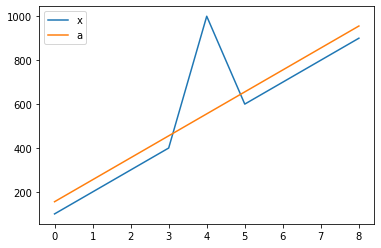

In [2]:
#https://stackoverflow.com/questions/58499114/calculate-a-rolling-regression-in-pandas-and-store-the-slope

import numpy as np
import pandas as pd
from scipy.stats import linregress

# create random sample data
days = 14
groups = ['A', 'B', 'C']
data_days = list(range(days)) * len(groups)
values = np.random.rand(days*len(groups))

df = pd.DataFrame(data=zip(sorted(groups*days), data_days, values), 
                  columns=['group', 'day', 'value'])

#https://stackoverflow.com/questions/58499114/calculate-a-rolling-regression-in-pandas-and-store-the-slope
    
def trend_approximation(array,debug=False):
    n = len(array)
    y = np.array(array)
    x = np.arange(n)
    slope, intercept, r_value, p_value, std_err = linregress(x,y)
    approximation = [intercept + i * slope for i in range(n)]
    # https://en.wikipedia.org/wiki/Variance
    variance = np.power(np.subtract(array,approximation),2).sum()/n
    # https://en.wikipedia.org/wiki/Standard_error
    # The standard error is, by definition, the standard deviation of X which is simply the square root of the variance 
    standard_error = math.sqrt(variance)
    trend = slope * (n - 1)
    if debug:
        print(trend, slope, intercept, r_value, p_value, std_err, variance, standard_error)
    return trend, standard_error, approximation


trend_approximation([1,2,3,4],debug=True)
trend_approximation([11,12,13,14],debug=True)
trend_approximation([10,12,13,15],debug=True)
trend_approximation([10,20,30,40,50,60],debug=True)
trend_approximation([10,20,10,20,10,20,10,20],debug=True)
trend_approximation([2,4,4,4,5,5,7,9],debug=True)

x = [100,200,300,400,1000,600,700,800,900]
t, e, a = trend_approximation(x,debug=True)

df = pd.DataFrame({'x':x,'a':a})
p = df.plot()


In [3]:
#OLD
def frame_normalize(df,column):
    label = column + 'N'
    df[label] = df[column] / df[column].abs().max()
def frame_diffnorm(df,column):
    label = column + 'DN'
    s = df[column]
    diff = s.diff()
    df[label] = diff/diff.abs().max()

#NEW
def frame_minmax(df,column):
    label = column + 'MM'
    bymean = df[column] - df[column].mean()
    df[label] = bymean / bymean.abs().max()
    
def frame_trend(df,column,n,norm=True):
    label = column + 'T' + str(n) + ('N' if norm else '')
    diffmean = df[column].diff().rolling(window=n,center=False,win_type='triang').mean()
    if norm:
        diffmean = diffmean / diffmean.abs().max()
    df[label] = diffmean

def frame_level(df,column,n,norm=True):
    label = column + 'V' + str(n) + ('N' if norm else '')
    variance = df[column] - df[column].rolling(window=n,center=False,win_type='triang').mean()
    if norm:
        variance = variance / variance.abs().max()
    df[label] = variance

def frame_range(df,column,n,norm=True):
    label = column + 'R' + str(n) + ('N' if norm else '')
    vmax = df[column].rolling(window=n,center=False).max()
    vmin = df[column].rolling(window=n,center=False).min()
    volatility = vmax - vmin
    if norm:
        volatility = volatility / volatility.abs().max()
    df[label] = volatility

def frame_std(df,column,n,norm=True):
    label = column + 'S' + str(n) + ('N' if norm else '')
    std = df[column].rolling(window=n,center=False).std()
    if norm:
        std = std / std.abs().max()
    df[label] = std

def frame_change(df,column,n,norm=True):
    label = column + 'C' + str(n) + ('N' if norm else '')
    chg = df[column] - df[column].shift(n-1)
    if norm:
        chg = chg / chg.abs().max()
    df[label] = chg


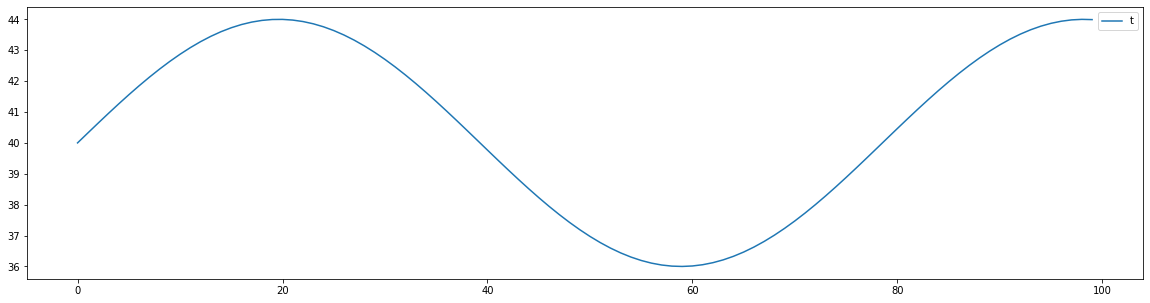

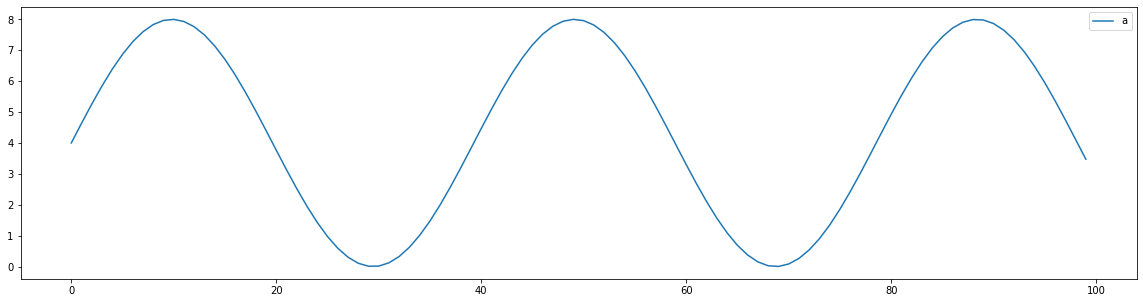

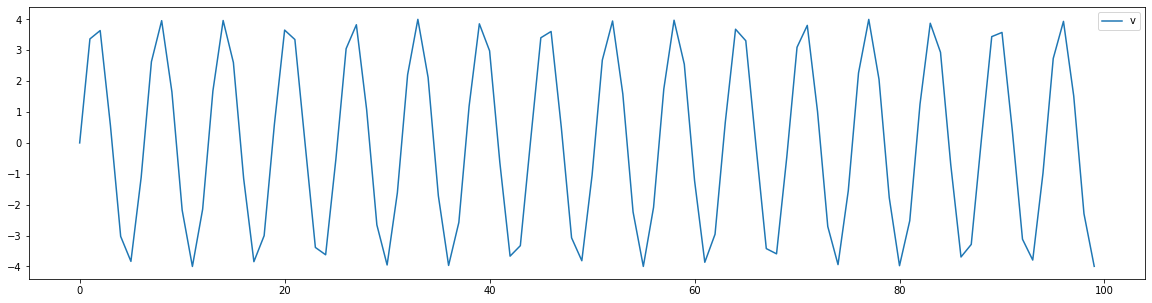

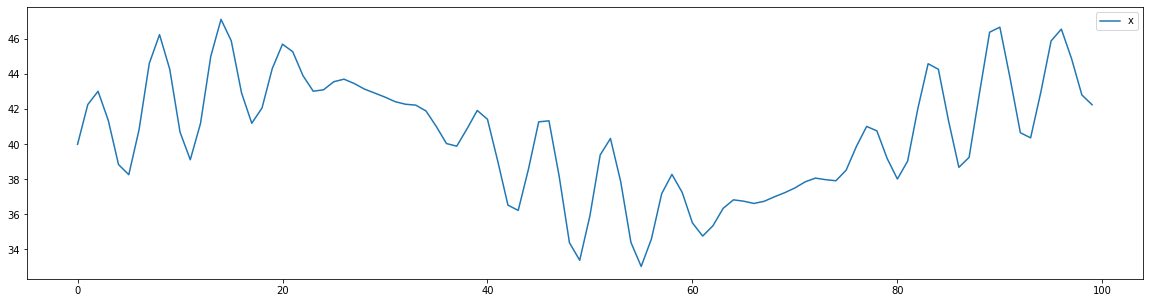

In [4]:
plt.rcParams["figure.figsize"] = (20,5)
t = [40+math.sin(i*0.08)*4 for i in range(0,100)]
a = [4+math.sin(i*0.16)*4 for i in range(0,100)]
v = [math.sin(i*1)*4 for i in range(0,100)]
x = [40+math.sin(i*0.08)*4 + math.sin(i*1)*(2+math.sin(i*0.16)*2) for i in range(0,100)]
x_df = pd.DataFrame({'t':t,'a':a,'v':v,'x':x})
p = x_df[['t']].plot()
p = x_df[['a']].plot()
p = x_df[['v']].plot()
p = x_df[['x']].plot()

frame_normalize(x_df,'x')
frame_diffnorm(x_df,'x')
frame_minmax(x_df,'x')


In [5]:
#TODO change vs error

def trendchange(a):
    tc, te, a = trend_approximation(a)
    return tc

def trenderror(a):
    tc, te, a = trend_approximation(a)
    return te

#TODO rolling/apply

def frame_trendchangerror(df,column,n,norm=True,debug=False):
    label_tc = column + 'TC' + str(n) + ('N' if norm else '')
    label_te = column + 'TE' + str(n) + ('N' if norm else '')
    
    data = list(df[column])
    tc = []
    te = []
    for i in range(len(df)):
        if i < (n-1):
            if debug:
                print(i)
            tc.append(np.nan)
            te.append(np.nan)
        else:
            d = data[i-n+1:i+1]
            #d = data.loc[i-n+1:i]
            c, e, a = trend_approximation(d)
            if debug:
                print(i,c,e,list(d),a)
            tc.append(c)
            te.append(e)
    if norm:
        tc = pd.Series(tc)
        te = pd.Series(te)
        tcabsmax = tc.abs().max()
        teabsmax = te.abs().max()
        if tcabsmax > 0:
            tc = tc / tcabsmax
        if teabsmax > 0:
            te = te / teabsmax
    #print(label_tc,label_te,len(df),len(tc),len(te))
    df[label_tc] = tc
    df[label_te] = te



0
1 1.0 0.0 [1, 2] [1.0, 2.0]
2 2.0 0.0 [2, 4] [2.0, 4.0]
3 4.0 0.0 [4, 8] [4.0, 8.0]
4 8.0 0.0 [8, 16] [8.0, 16.0]


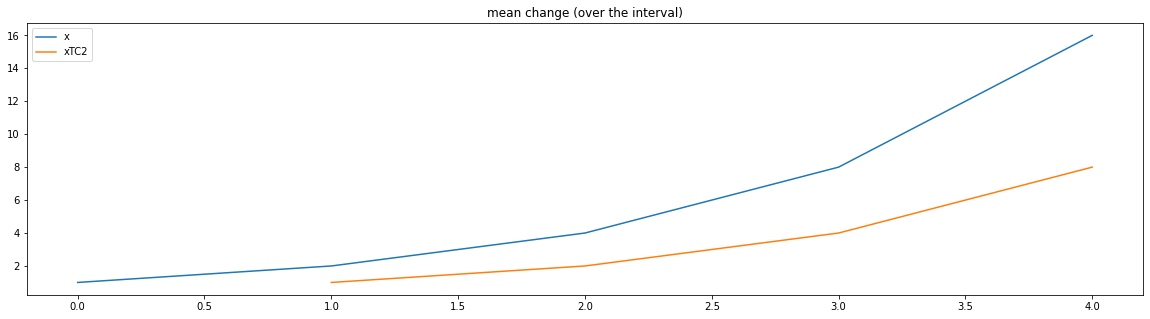

In [6]:
x_df5= pd.DataFrame({'x':[1,2,4,8,16]})
frame_trendchangerror(x_df5,'x',2,norm=False,debug=True)
x_df5

p = x_df5[['x','xTC2']].plot(title = 'mean change (over the interval)')


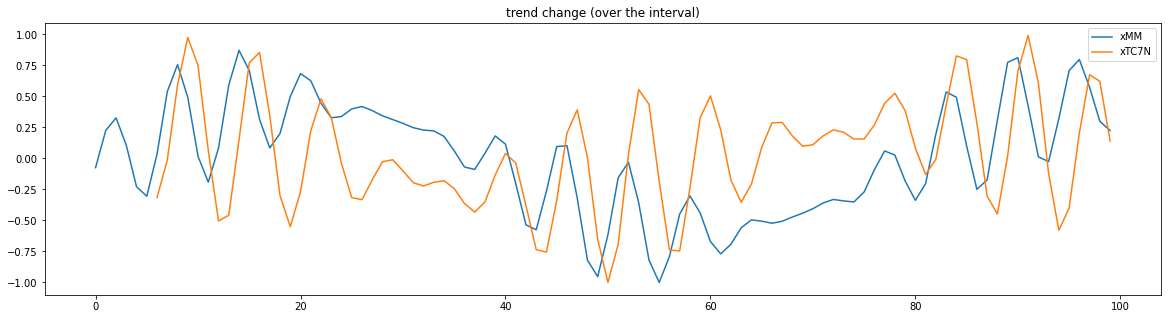

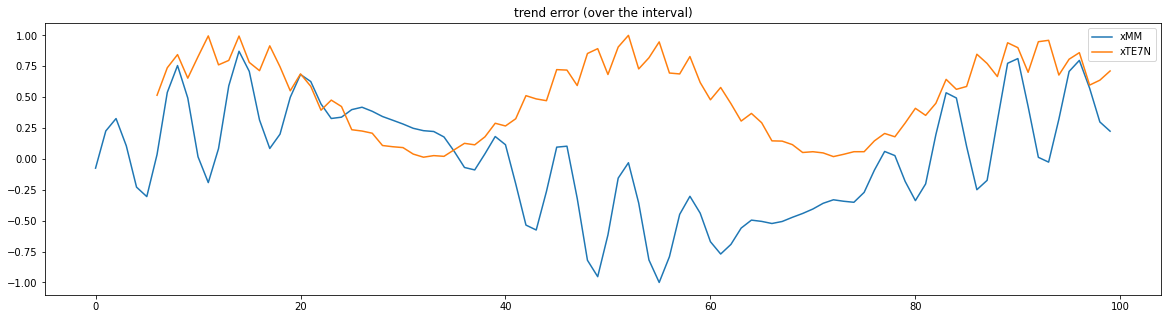

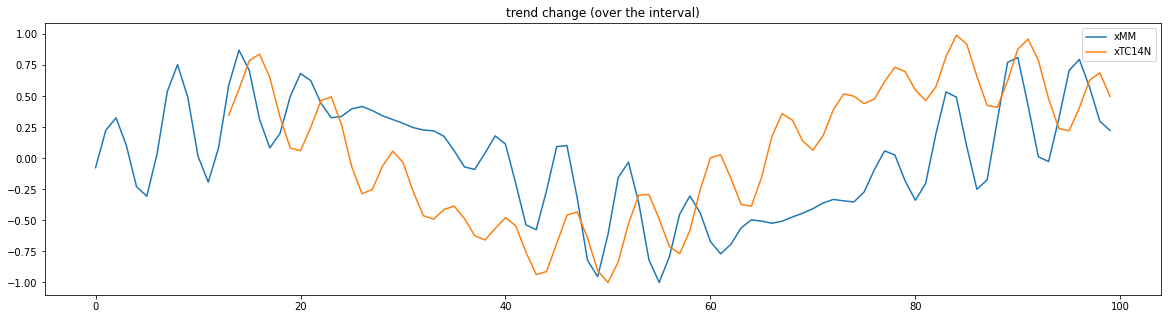

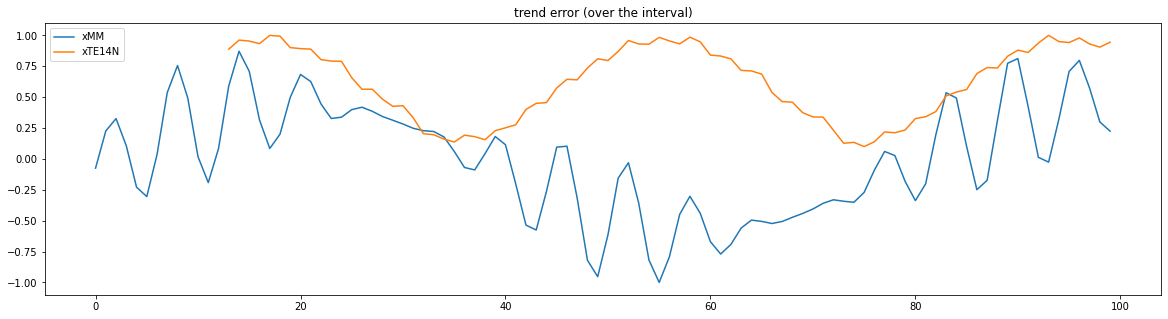

In [7]:
frame_trendchangerror(x_df,'x',7,norm=True,debug=False)
frame_trendchangerror(x_df,'x',14,norm=True,debug=False)
p = x_df[['xMM','xTC7N']].plot(title = 'trend change (over the interval)')
p = x_df[['xMM','xTE7N']].plot(title = 'trend error (over the interval)')
p = x_df[['xMM','xTC14N']].plot(title = 'trend change (over the interval)')
p = x_df[['xMM','xTE14N']].plot(title = 'trend error (over the interval)')


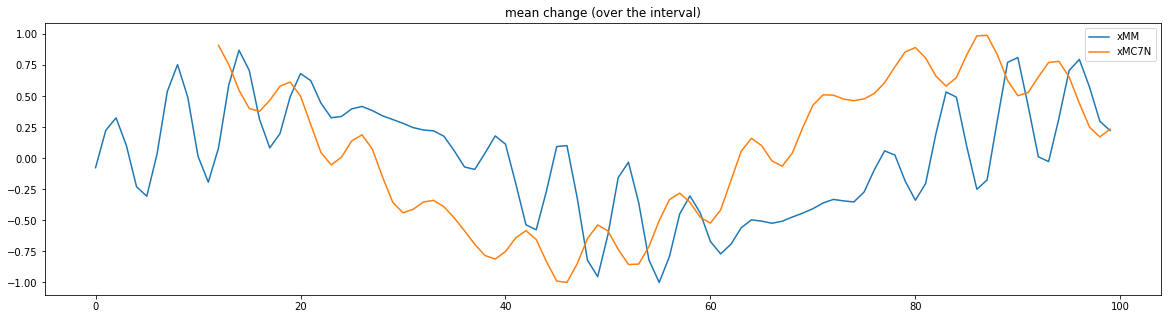

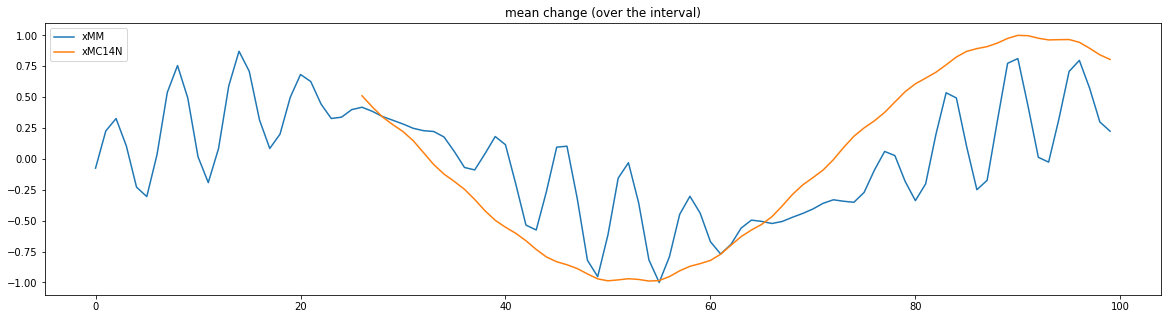

In [8]:
def frame_meanchange(df,column,n,norm=True):
    label = column + 'MC' + str(n) + ('N' if norm else '')
    mean = df[column].rolling(window=n,center=False,win_type='triang').mean()
    chg = mean - mean.shift(n-1)
    if norm:
        chg = chg / chg.abs().max()
    df[label] = chg

frame_meanchange(x_df,'x',7)
frame_meanchange(x_df,'x',14)
p = x_df[['xMM','xMC7N']].plot(title = 'mean change (over the interval)')
p = x_df[['xMM','xMC14N']].plot(title = 'mean change (over the interval)')


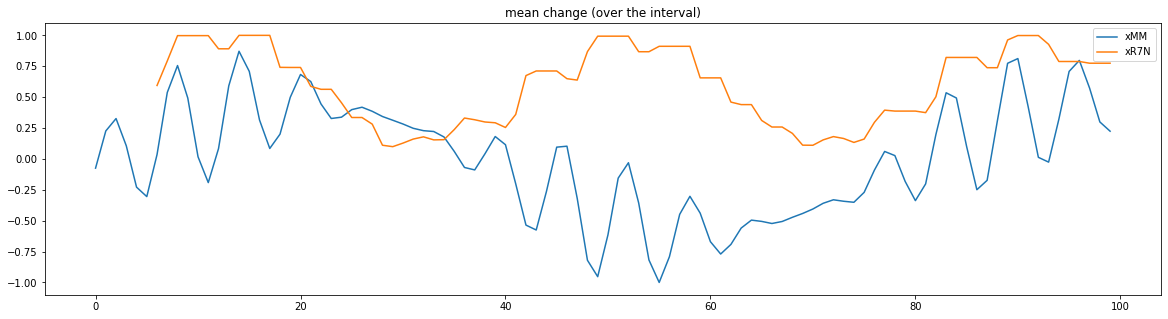

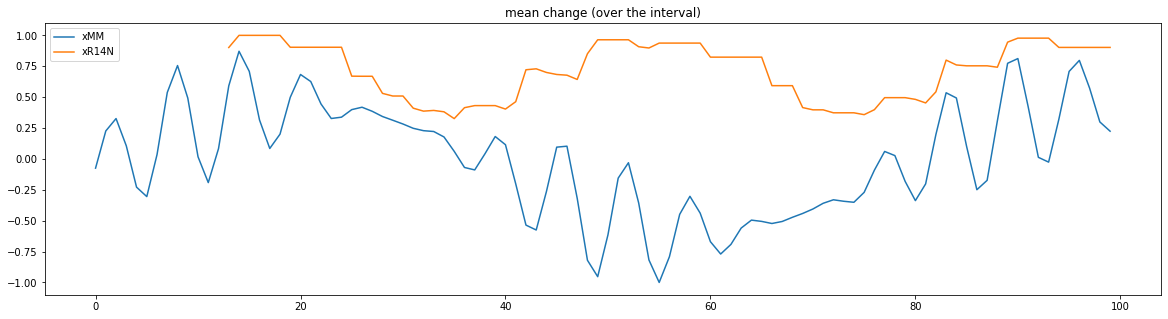

In [9]:
frame_range(x_df,'x',7)
frame_range(x_df,'x',14)
p = x_df[['xMM','xR7N']].plot(title = 'mean change (over the interval)')
p = x_df[['xMM','xR14N']].plot(title = 'mean change (over the interval)')


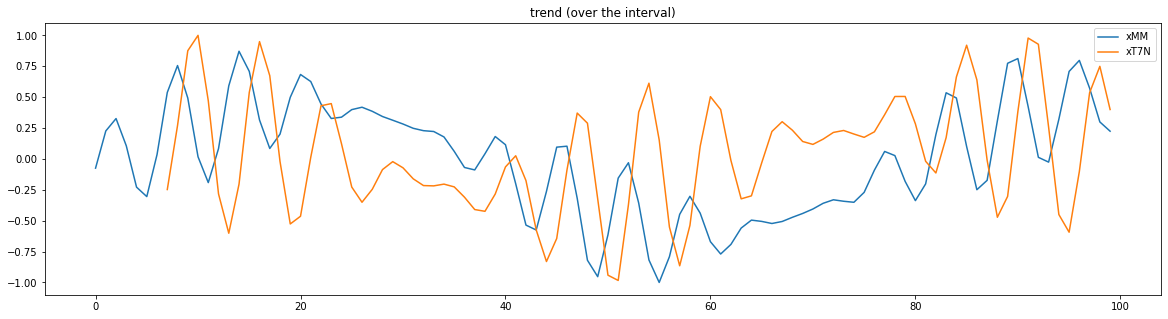

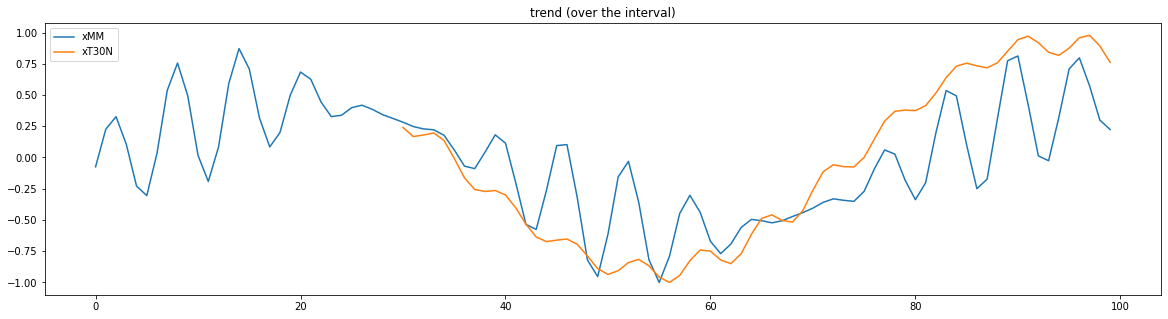

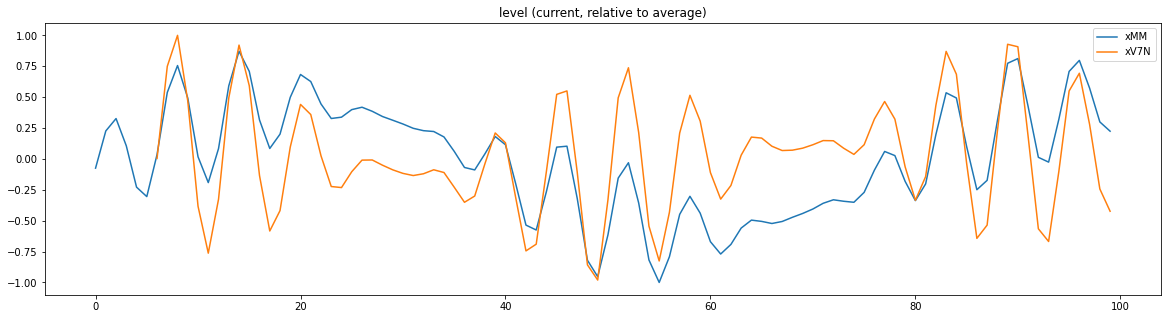

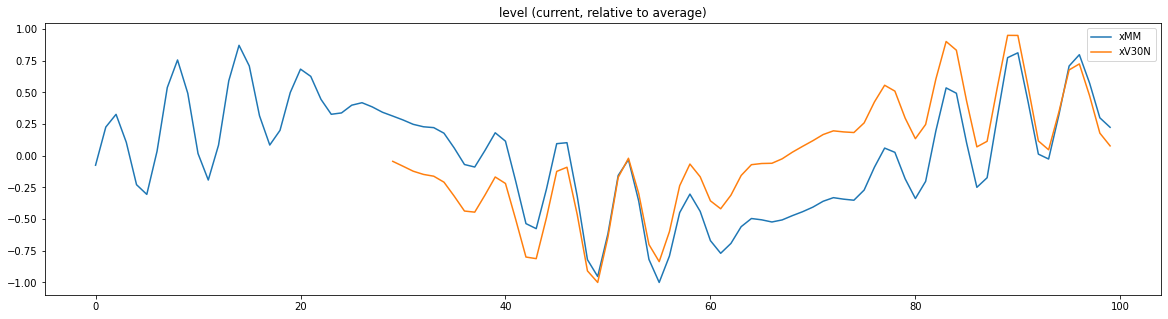

In [10]:
frame_trend(x_df,'x',7)
frame_trend(x_df,'x',30)
p = x_df[['xMM','xT7N']].plot(title = 'trend (over the interval)')
p = x_df[['xMM','xT30N']].plot(title = 'trend (over the interval)')

frame_level(x_df,'x',7)
frame_level(x_df,'x',30)
p = x_df[['xMM','xV7N']].plot(title = 'level (current, relative to average)')
p = x_df[['xMM','xV30N']].plot(title = 'level (current, relative to average)')


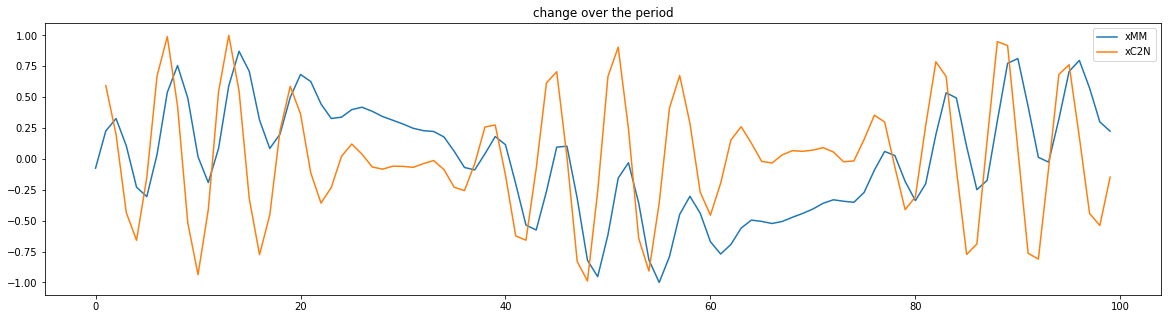

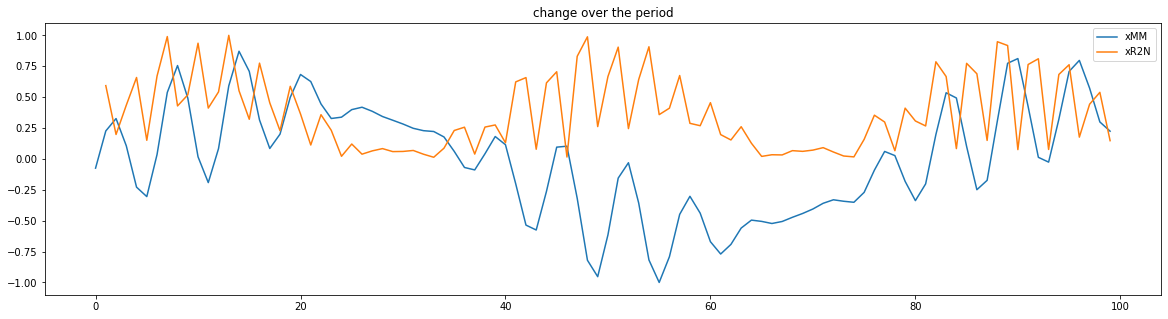

In [11]:
frame_minmax(x_df,'x')
frame_change(x_df,'x',2,norm=True)
frame_range(x_df,'x',2,norm=True)
p = x_df[['xMM','xC2N']].plot(title = 'change over the period')
p = x_df[['xMM','xR2N']].plot(title = 'change over the period')


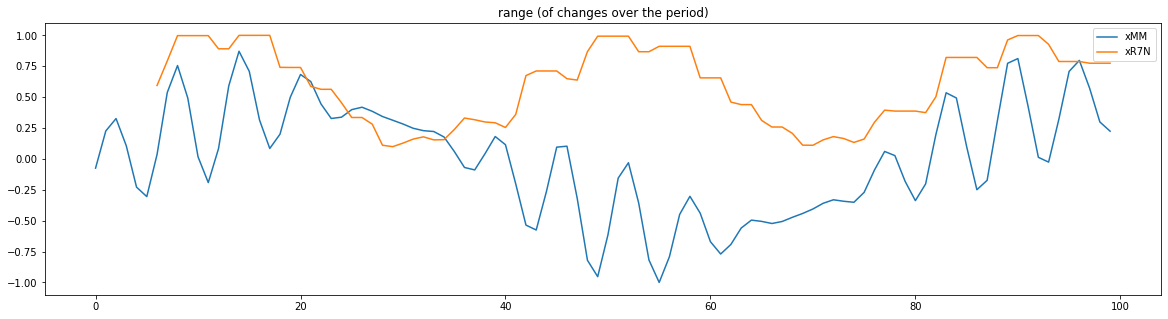

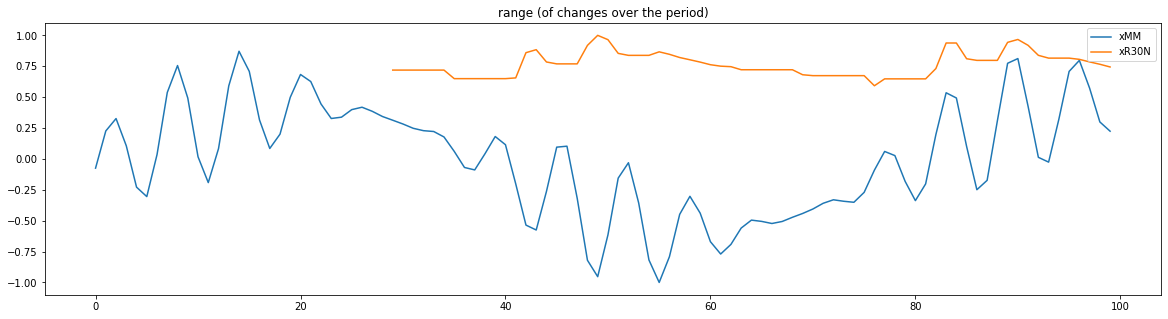

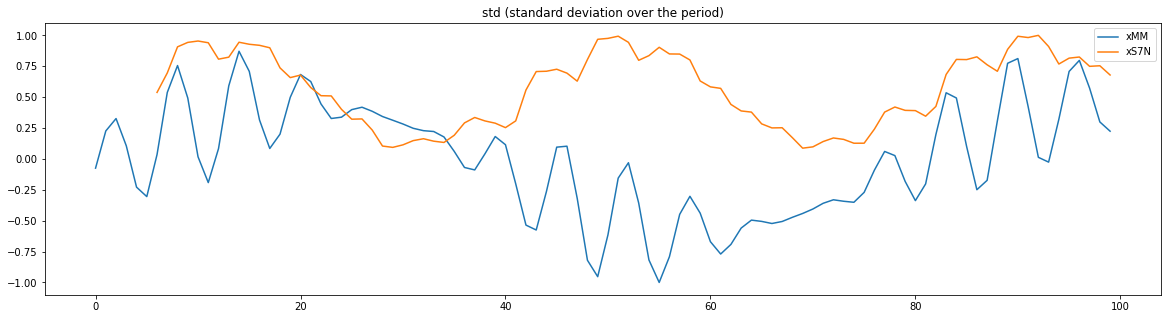

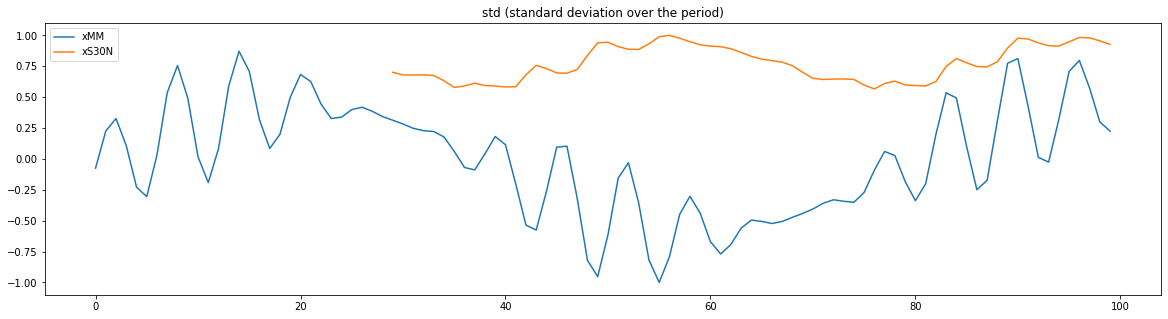

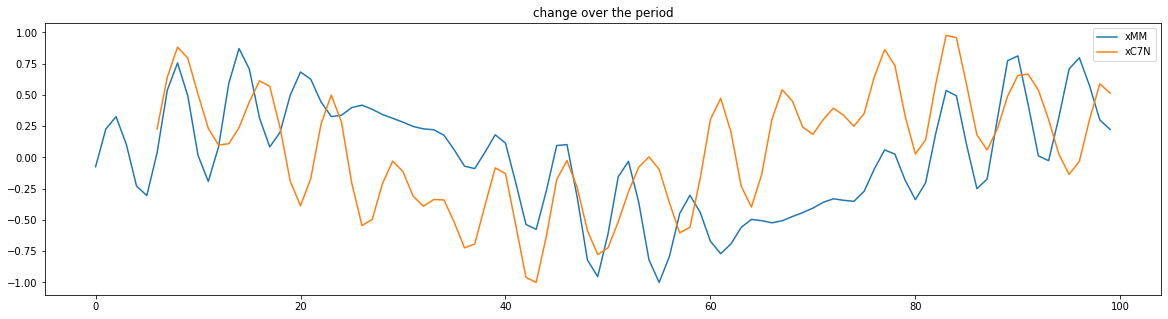

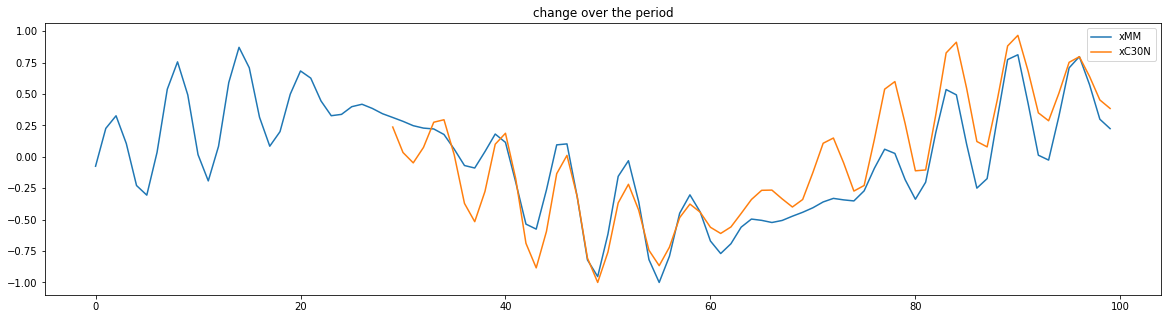

In [12]:
frame_range(x_df,'x',7,norm=True)
frame_range(x_df,'x',30,norm=True)
p = x_df[['xMM','xR7N']].plot(title = 'range (of changes over the period)')
p = x_df[['xMM','xR30N']].plot(title = 'range (of changes over the period)')

frame_std(x_df,'x',7,norm=True)
frame_std(x_df,'x',30,norm=True)
p = x_df[['xMM','xS7N']].plot(title = 'std (standard deviation over the period)')
p = x_df[['xMM','xS30N']].plot(title = 'std (standard deviation over the period)')

frame_change(x_df,'x',7,norm=True)
frame_change(x_df,'x',30,norm=True)
p = x_df[['xMM','xC7N']].plot(title = 'change over the period')
p = x_df[['xMM','xC30N']].plot(title = 'change over the period')



In [13]:
x_df

,t,a,v,x,xN,xDN,xMM,xTC7N,xTE7N,xTC14N,...,xT30N,xV7N,xV30N,xC2N,xR2N,xR30N,xS7N,xS30N,xC7N,xC30N
0,40.000000,4.000000,0.000000,40.000000,0.848617,NaN,-0.074952,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,40.319659,4.637273,3.365884,42.270724,0.896791,0.593121,0.226179,NaN,NaN,NaN,...,NaN,NaN,NaN,0.593121,0.593121,NaN,NaN,NaN,NaN,NaN
2,40.637273,5.258266,3.637190,43.027937,0.912856,0.197787,0.326596,NaN,NaN,NaN,...,NaN,NaN,NaN,0.197787,0.197787,NaN,NaN,NaN,NaN,NaN
3,40.950811,5.847117,0.564480,41.363383,0.877542,-0.434787,0.105852,NaN,NaN,NaN,...,NaN,NaN,NaN,-0.434787,0.434787,NaN,NaN,NaN,NaN,NaN
4,41.258266,6.388782,-3.027210,38.840743,0.824023,-0.658923,-0.228686,NaN,NaN,NaN,...,NaN,NaN,NaN,-0.658923,0.658923,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,43.871679,5.945595,2.733047,45.902877,0.973849,0.762248,0.707855,-0.400218,0.806887,0.221932,...,0.874459,0.549613,0.677044,0.762248,0.762248,0.815733,0.815569,0.948132,-0.135905,0.752012
96,43.939613,5.363935,3.934351,46.577564,0.988163,0.176231,0.797328,0.203868,0.859832,0.407563,...,0.958249,0.693229,0.724398,0.176231,0.176231,0.805763,0.824638,0.982817,-0.030458,0.796712
97,43.982348,4.747434,1.518431,44.883429,0.952221,-0.442514,0.572662,0.674330,0.597337,0.629825,...,0.977180,0.279194,0.472960,-0.442514,0.442514,0.785049,0.749257,0.980177,0.305197,0.638722
98,43.999609,4.111838,-2.293527,42.820782,0.908461,-0.538771,0.299125,0.621510,0.637110,0.688667,...,0.892590,-0.243462,0.178467,-0.538771,0.538771,0.766095,0.753887,0.955116,0.588889,0.452630


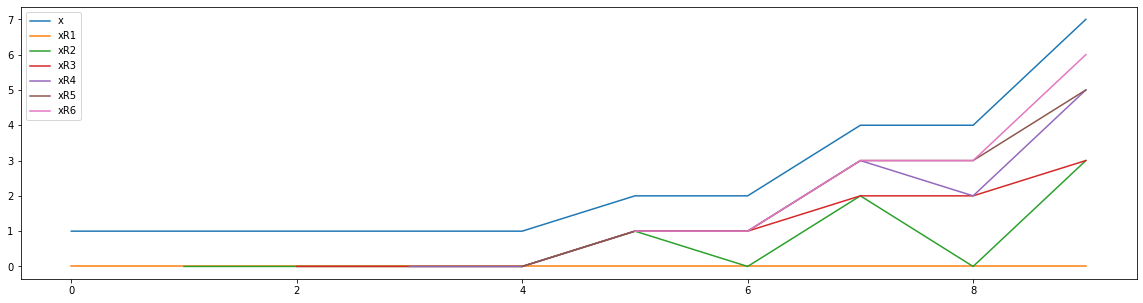

In [14]:
y_df = pd.DataFrame([1,1,1,1,1,2,2,4,4,7],columns=['x'])
frame_range(y_df,'x',1,norm=False)
frame_range(y_df,'x',2,norm=False)
frame_range(y_df,'x',3,norm=False)
frame_range(y_df,'x',4,norm=False)
frame_range(y_df,'x',5,norm=False)
frame_range(y_df,'x',6,norm=False)
p = y_df.plot()
